# Specify a star catalog from pixel coordinates

## Goal

Run PlatoSim for one or more stars that you specify in CCD coordinates instead of equatorial coordinates (RA, Dec). This is especially useful when you want to simulate features at a specific location on the CCD or if you want to supply a grid of stars equally distributed over the PLATO CCDs.

<img src='CoordinatesTransformations.png'>

Methods that we will focus on are imported from referenceFrames.py.

* pixelToSkyCoordinates
* skyToPixelCoordinates

These are convenience methods that combine the above steps in one simple function and take field distortion into account.

## Set up your environment

In [103]:
projectDir = "/Users/rik/Git/PlatoSim3"
workDir = "/Users/rik/Work/PLATO/Simulations"

In [104]:
%run -i setupEnvironment.py

In [105]:
%matplotlib inline

%run -i setupMatplotlib.py

## Import the relevant modules

In [178]:
from imp import reload

In [179]:
import numpy as np

In [180]:
import simulation
reload(simulation)
from simulation import Simulation

In [181]:
import simfile
reload(simfile)
from simfile import SimFile

In [182]:
import referenceFrames
reload(referenceFrames)
from referenceFrames import pixelToSkyCoordinates, skyToPixelCoordinates
from referenceFrames import setSubfieldAroundCoordinates, setSubfieldAroundPixelCoordinates
from referenceFrames import platformToTelescopePointingCoordinates
from referenceFrames import drawCCDsInSky, drawCCDsInFocalPlane
from referenceFrames import drawSubfieldInFocalPlane
from referenceFrames import drawStarInFocalPlane

## Create and configure a Simulation

In [183]:
sim = Simulation("Run01", outputDir = workDir)

In [184]:
sim["Camera/IncludeFieldDistortion"] = "no"

In [185]:
ccdCode = 'B'
xCCDpixel = 3800 
yCCDpixel = 3800
subfieldSizeX = 50
subfieldSizeY = 50

In [186]:
ra, dec = pixelToSkyCoordinates(sim, ccdCode, xCCDpixel, yCCDpixel)

In [187]:
setSubfieldAroundCoordinates(sim, ra, dec, subfieldSizeX, subfieldSizeY, normal=True)

True

## Make a starCatalog with stars of identical magnitude lying over the diagonals of each CCD

In [188]:
starCatalogFilename = workDir + "/generatedFromPixelCoordinates.starcat"

In [189]:
ccdCode = 'B'

In [190]:
vMag = []
raStar = []
decStar = []

for x in range(255, 4510, 200):
    ra, dec = pixelToSkyCoordinates(sim, ccdCode, x, x)
    
    raStar.append(ra)
    decStar.append(dec)
    vMag.append(12.5)
    
for x in range(255, 4510, 200):
    ra, dec = pixelToSkyCoordinates(sim, ccdCode, x, 4510 - x)
    
    raStar.append(ra)
    decStar.append(dec)
    vMag.append(12.5)

raStar = np.array(raStar)
decStar = np.array(decStar)
vMag = np.array(vMag)


In [191]:
np.savetxt(starCatalogFilename, np.transpose([raStar, decStar, vMag]), fmt=['%11.6f', '%11.6f', '%8.4f'])

Update the simulation parameters to pick up the new star catalog and set the subField around one of the stars.

In [192]:
sim["ObservingParameters/StarCatalogFile"] = starCatalogFilename

In [193]:
setSubfieldAroundCoordinates(sim, ra, dec, subfieldSizeX, subfieldSizeY, normal=True)

True

In [194]:
setSubfieldAroundPixelCoordinates(sim, ccdCode, 255, 255, subfieldSizeX, subfieldSizeY)

In [195]:
RA_PLATFORM  = np.deg2rad(float(sim["ObservingParameters/RApointing"]))
DEC_PLATFORM = np.deg2rad(float(sim["ObservingParameters/DecPointing"]))

In [196]:
azimuth = np.deg2rad(float(sim["Telescope/AzimuthAngle"]))
tilt    = np.deg2rad(float(sim["Telescope/TiltAngle"]))

In [197]:
RA_TELESCOPE, DEC_TELESCOPE = platformToTelescopePointingCoordinates(RA_PLATFORM, DEC_PLATFORM, azimuth, tilt)

In [198]:
focalPlaneAngle = float(sim["Camera/FocalPlaneOrientation"])
focalLength     = float(sim["Camera/FocalLength"])*1000.                       # [m] -> [mm]
pixelSize       = float(sim["CCD/PixelSize"])

## Checking the result

In [199]:
%matplotlib inline
%run setupMatplotlib.py

#### Plot the CCDs and stars from the star catalog on the Sky.

(50.0, 300.0, -100.0, -40.0)

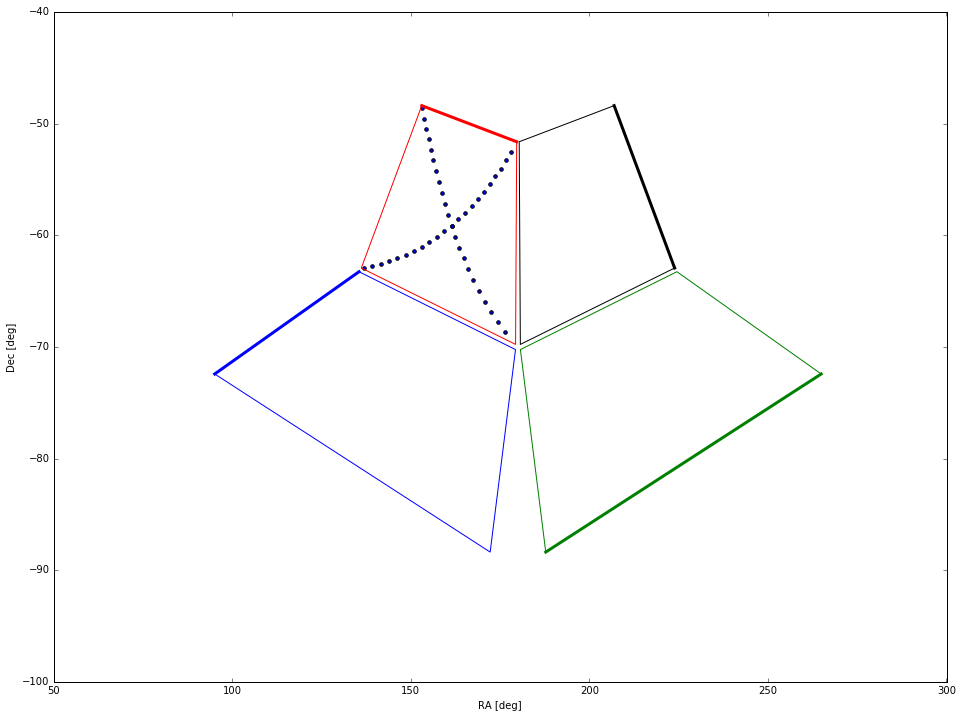

In [200]:
drawCCDsInSky(RA_TELESCOPE, DEC_TELESCOPE, focalPlaneAngle, focalLength, pixelSize)
plt.scatter(np.rad2deg(raStar), np.rad2deg(decStar), 12.5)
plt.axis('auto')

In [201]:
raStar.__len__


<method-wrapper '__len__' of numpy.ndarray object at 0x1106893f0>

#### Plot the CCDs and the stars from the star catalog in the focal plane.

Load the star catalog that was generated from the pixel coordinates.

In [202]:
ra, dec, Vmag = np.loadtxt(starCatalogFilename, unpack=True)
Nstars = len(ra)

(-100.0, 100.0, -100.0, 100.0)

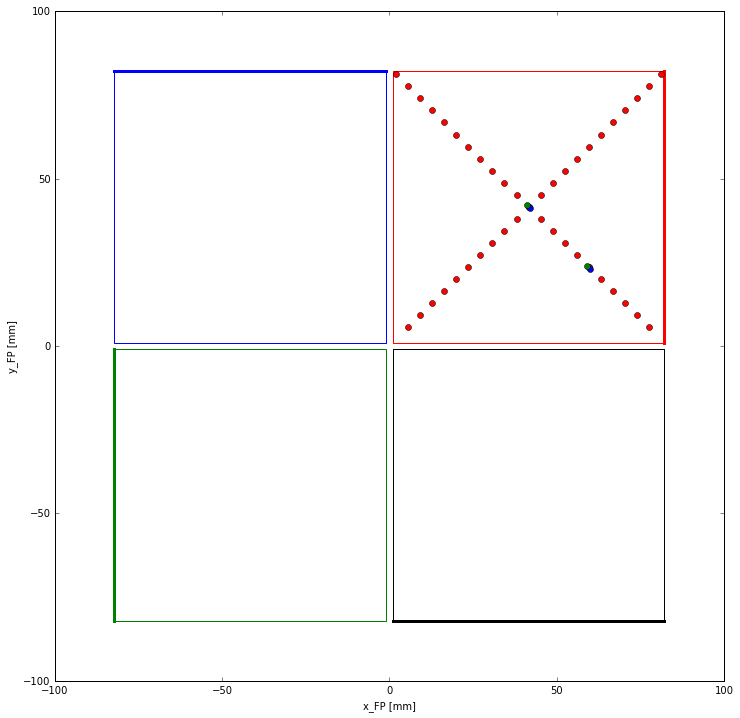

In [203]:
drawCCDsInFocalPlane(pixelSize)
for idx in range(0, Nstars):
    drawStarInFocalPlane(sim, ra[idx], dec[idx])

drawSubfieldInFocalPlane(ccdCode, 4510/2, 4510/2, subfieldSizeX, subfieldSizeY, pixelSize)

ccdCode, xCCDpixel, yCCDpixel = skyToPixelCoordinates(sim, ra[5], dec[5], normal=True)
drawSubfieldInFocalPlane(ccdCode, xCCDpixel, yCCDpixel, subfieldSizeX, subfieldSizeY, pixelSize)
plt.axis('scaled')